# Feedbacks CERES via LW fluxes

(1) Reconstruit les données avec les PCs et EOFs des flux LW. 

(2) Multi Linéaire Régression des PCs sur les feedbacks pour trouver les coefficients Beta. 

(3) Retrouver les PCs des observations CERES. 

(4) Prédire les feedbacks des observations.

# Importe modules

In [2]:
# Computational modules 
%matplotlib inline
import xarray as xr
import glob
import os
import numpy as np
import netCDF4
from netCDF4 import Dataset
import pandas as pd
import re
from array import array
from pylab import *
#import geopandas
from eofs.xarray import Eof
from eofs.multivariate.standard import MultivariateEof

# Plotting modules 
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pandas.plotting
import matplotlib.ticker as ticker
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm

# Scikit-learn
from sklearn import linear_model
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.neural_network import MLPRegressor

# Functions definition

In [3]:
import sys
sys.path.append('/data/home/globc/peatier/CNRMppe')
import Fonctions
from Fonctions import get_wavg_budget_df
from Fonctions import wavg 
from Fonctions import plotlines_Xdf
from Fonctions import plotlines_1df
from Fonctions import Deltas_Lambda
from Fonctions import get_3D_budget_xarr
from Fonctions import get_3D_xarr
from Fonctions import get_3D_SW_xarr
from Fonctions import get_3D_LW_xarr

# EOF, SW_mean and PCs

In [4]:
LW_mean =  pd.read_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_LW_mean.npy').to_xarray().to_array()
LW_mean = LW_mean[0,:,:].rename({'variable':'mode'})
LW_mean

<xarray.DataArray (lat: 128, lon: 256)>
array([[141.47495, 141.47495, 141.47495, ..., 141.47495, 141.47495,
        141.47495],
       [144.49937, 144.49937, 144.49937, ..., 144.49937, 144.49937,
        144.49937],
       [145.12088, 145.12088, 145.12088, ..., 145.85733, 145.12088,
        145.12088],
       ...,
       [189.56772, 189.56772, 189.56772, ..., 189.64738, 189.56772,
        189.56772],
       [189.52794, 189.52794, 189.52794, ..., 189.52794, 189.52794,
        189.52794],
       [187.78711, 187.78711, 187.78711, ..., 187.78711, 187.78711,
        187.78711]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
    mode     <U8 'rlutmean'

In [5]:
LW_anom =  pd.read_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_LW_anom.npy').to_xarray().to_array()
LW_anom = LW_anom[0,:,:].rename({'variable':'mode'})
LW_anom

<xarray.DataArray (time: 104, lat: 128, lon: 256)>
array([[[-0.15753174, -0.15753174, -0.15753174, ..., -0.15753174,
         -0.15753174, -0.15753174],
        [-0.93562317, -0.93562317, -0.93562317, ..., -0.93562317,
         -0.93562317, -0.93562317],
        [-1.183258  , -1.183258  , -1.183258  , ..., -1.1234894 ,
         -1.183258  , -1.183258  ],
        ...,
        [ 2.3677979 ,  2.3677979 ,  2.3677979 , ...,  2.3114777 ,
          2.3677979 ,  2.3677979 ],
        [ 2.5720673 ,  2.5720673 ,  2.5720673 , ...,  2.5720673 ,
          2.5720673 ,  2.5720673 ],
        [ 2.7663422 ,  2.7663422 ,  2.7663422 , ...,  2.7663422 ,
          2.7663422 ,  2.7663422 ]],

       [[-0.25358582, -0.25358582, -0.25358582, ..., -0.25358582,
         -0.25358582, -0.25358582],
        [-1.3831329 , -1.3831329 , -1.3831329 , ..., -1.3831329 ,
         -1.3831329 , -1.3831329 ],
        [-2.0042114 , -2.0042114 , -2.0042114 , ..., -1.8739624 ,
         -2.0042114 , -2.0042114 ],
        ...,
        [ 2.0300446 ,  2.0300446 ,  2.0300446 , ...,  2.0138397 ,
          2.0300446 ,  2.0300446 ],
        [ 2.4886017 ,  2.4886017 ,  2.4886017 , ...,  2.4886017 ,
          2.4886017 ,  2.4886017 ],
        [ 3.1971283 ,  3.1971283 ,  3.1971283 , ...,  3.1971283 ,
          3.1971283 ,  3.1971283 ]],

       [[ 2.4591675 ,  2.4591675 ,  2.4591675 , ...,  2.4591675 ,
          2.4591675 ,  2.4591675 ],
        [ 2.7849884 ,  2.7849884 ,  2.7849884 , ...,  2.7849884 ,
          2.7849884 ,  2.7849884 ],
        [ 3.723114  ,  3.723114  ,  3.723114  , ...,  3.5867767 ,
          3.723114  ,  3.723114  ],
        ...,
        [-0.7435913 , -0.7435913 , -0.7435913 , ..., -0.75328064,
         -0.7435913 , -0.7435913 ],
        [-0.5712433 , -0.5712433 , -0.5712433 , ..., -0.5712433 ,
         -0.5712433 , -0.5712433 ],
        [-0.58695984, -0.58695984, -0.58695984, ..., -0.58695984,
         -0.58695984, -0.58695984]],

       ...,

       [[ 0.9213867 ,  0.9213867 ,  0.9213867 , ...,  0.9213867 ,
          0.9213867 ,  0.9213867 ],
        [-0.5202942 , -0.5202942 , -0.5202942 , ..., -0.5202942 ,
         -0.5202942 , -0.5202942 ],
        [-0.9635925 , -0.9635925 , -0.9635925 , ..., -1.0771484 ,
         -0.9635925 , -0.9635925 ],
        ...,
        [-1.6254425 , -1.6254425 , -1.6254425 , ..., -1.6356049 ,
         -1.6254425 , -1.6254425 ],
        [-1.7259827 , -1.7259827 , -1.7259827 , ..., -1.7259827 ,
         -1.7259827 , -1.7259827 ],
        [-1.4056244 , -1.4056244 , -1.4056244 , ..., -1.4056244 ,
         -1.4056244 , -1.4056244 ]],

       [[-1.5286255 , -1.5286255 , -1.5286255 , ..., -1.5286255 ,
         -1.5286255 , -1.5286255 ],
        [-2.1253815 , -2.1253815 , -2.1253815 , ..., -2.1253815 ,
         -2.1253815 , -2.1253815 ],
        [-3.006485  , -3.006485  , -3.006485  , ..., -2.7653198 ,
         -3.006485  , -3.006485  ],
        ...,
        [-0.93640137, -0.93640137, -0.93640137, ..., -1.0320587 ,
         -0.93640137, -0.93640137],
        [-1.9666443 , -1.9666443 , -1.9666443 , ..., -1.9666443 ,
         -1.9666443 , -1.9666443 ],
        [-2.2373047 , -2.2373047 , -2.2373047 , ..., -2.2373047 ,
         -2.2373047 , -2.2373047 ]],

       [[-1.7113342 , -1.7113342 , -1.7113342 , ..., -1.7113342 ,
         -1.7113342 , -1.7113342 ],
        [-2.4022675 , -2.4022675 , -2.4022675 , ..., -2.4022675 ,
         -2.4022675 , -2.4022675 ],
        [-2.959198  , -2.959198  , -2.959198  , ..., -2.9439545 ,
         -2.959198  , -2.959198  ],
        ...,
        [ 2.1657562 ,  2.1657562 ,  2.1657562 , ...,  2.1085663 ,
          2.1657562 ,  2.1657562 ],
        [ 1.6786346 ,  1.6786346 ,  1.6786346 , ...,  1.6786346 ,
          1.6786346 ,  1.6786346 ],
        [ 1.339447  ,  1.339447  ,  1.339447  , ...,  1.339447  ,
          1.339447  ,  1.339447  ]]], dtype=float32)
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 95 96 97 98 99 100 101 102 103
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 

In [6]:
eof1 = pd.read_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOFmap1_LW.npy').to_xarray().to_array()
eof2 = pd.read_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOFmap2_LW.npy').to_xarray().to_array()
eof3 = pd.read_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOFmap3_LW.npy').to_xarray().to_array()
eof4 = pd.read_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOFmap4_LW.npy').to_xarray().to_array()
eof5 = pd.read_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOFmap5_LW.npy').to_xarray().to_array()

eof1 = eof1[0,:,:].rename({'variable':'mode'})
eof2 = eof2[0,:,:].rename({'variable':'mode'})
eof3 = eof3[0,:,:].rename({'variable':'mode'})
eof4 = eof4[0,:,:].rename({'variable':'mode'})
eof5 = eof5[0,:,:].rename({'variable':'mode'})

eofs = [eof1,eof2,eof3,eof4,eof5]

In [7]:
eofs_combined = xr.combine_nested(eofs, concat_dim='eofs')
#eofs_combined

In [8]:
pc1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF1pc_LW.npy')
pc2 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF2pc_LW.npy')
pc3 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF3pc_LW.npy')
pc4 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF4pc_LW.npy')
pc5 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF5pc_LW.npy')

PC_df = pd.DataFrame(pc1)
PC_df['pc1'] = pc1
PC_df['pc2'] = pc2
PC_df['pc3'] = pc3
PC_df['pc4'] = pc4
PC_df['pc5'] = pc5
PC_df = PC_df.drop(labels = 0, axis=1)
#PC_df

PC_df

,pc1,pc2,pc3,pc4,pc5
0,-0.739219,0.068012,0.231087,-0.114967,-2.073620
1,0.336901,-0.589367,1.022992,0.410326,0.460474
2,1.772028,0.713022,0.389880,0.341204,-0.621712
3,0.602520,-1.191535,1.601341,-0.169788,0.693402
4,0.675742,-0.056017,-0.160190,1.804740,-0.257126
...,...,...,...,...,...
97,-0.303779,-0.121118,1.087760,0.318875,0.982107
98,-0.210095,-1.715702,-1.029760,1.346775,1.742032
99,0.184986,-0.692581,-0.455570,0.427989,0.221776
100,0.761945,-0.390530,0.032001,0.808282,-0.055405


In [9]:
pc1_official = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/official_EOF1pc_LW.npy')
pc2_official = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/official_EOF2pc_LW.npy')
pc3_official = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/official_EOF3pc_LW.npy')
pc4_official = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/official_EOF4pc_LW.npy')
pc5_official = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/official_EOF5pc_LW.npy')

pc1_p1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/p1_EOF1pc_LW.npy')
pc2_p1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/p1_EOF2pc_LW.npy')
pc3_p1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/p1_EOF3pc_LW.npy')
pc4_p1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/p1_EOF4pc_LW.npy')
pc5_p1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/p1_EOF5pc_LW.npy')

In [10]:
PCs = [0]*102
for i in range(0,102,1):
    tmp = PC_df.iloc[i].values
    PCs[i] = tmp

PCs

[array([-0.739219  ,  0.06801169,  0.23108684, -0.11496683, -2.0736196 ],
       dtype=float32),
 array([ 0.33690146, -0.589367  ,  1.0229925 ,  0.41032562,  0.46047366],
       dtype=float32),
 array([ 1.7720282 ,  0.71302193,  0.3898799 ,  0.34120384, -0.62171173],
       dtype=float32),
 array([ 0.6025199 , -1.1915354 ,  1.6013405 , -0.16978788,  0.6934018 ],
       dtype=float32),
 array([ 0.6757417 , -0.05601668, -0.16019036,  1.8047398 , -0.25712574],
       dtype=float32),
 array([ 0.84083104,  1.6639265 , -0.12907813, -0.18733302, -0.27295816],
       dtype=float32),
 array([ 0.7647841 , -1.1892354 ,  0.23717833, -0.28449625, -0.92981225],
       dtype=float32),
 array([ 0.5160375,  0.6758825, -0.3224069, -0.965911 ,  0.2885291],
       dtype=float32),
 array([ 0.616291  , -0.9146413 , -0.6743382 , -1.0695827 , -0.39938933],
       dtype=float32),
 array([-0.2958961 ,  1.4522847 ,  0.8670382 , -1.9481598 ,  0.18674015],
       dtype=float32),
 array([ 0.5475291 , -0.8513141 , -

# Trouver U_obs : Reconstruciton des données

X_ens = U_ens(pc) * v_ens(eof) 

Compute anomaly : X_obs = X_obs - SW_mean_ens 

X_obs = U_obs * v_ens 

U_obs = X_obs * inv(v_ens)

## Get the CERES datatset

In [11]:
def load_monthly_clim(path, filename, variables) :
    
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    df=file[variables].to_dataframe()
    
    # Compute Climatological Annual Cycle :
    df1=df.reset_index(level=['time', 'lat', 'lon'])
    df1['month']=pd.DatetimeIndex(df1['time']).month # time in years
    df_mean=df1.groupby(['month', 'lat', 'lon']).mean()
    
    return df_mean

In [12]:
path_observation = '/data/home/globc/peatier/obs_data/CERES/'
filename = 'CERES_EBAF-TOA_Ed4.1_Subset_200003-201910_regrid.nc'
    
# Load data and compute Annual Cycle :
file = xr.open_mfdataset(path_observation+filename,combine='by_coords')
#file
variables = ['toa_sw_all_mon','toa_lw_all_mon', 'toa_net_all_mon']
df_obs = load_monthly_clim(path_observation, filename, variables)
df_obs

toa_sw_all_mon  toa_lw_all_mon  toa_net_all_mon
month lat        lon                                                       
1     -88.927735 0.00000        344.953522      189.246185       -38.599289
                 1.40625        344.953522      189.246185       -38.599289
                 2.81250        344.953522      189.246185       -38.599289
                 4.21875        344.992493      189.144440       -38.531315
                 5.62500        345.007721      189.104630       -38.504715
...                                    ...             ...              ...
12     88.927735 352.96875        0.000000      171.476639      -171.476639
                 354.37500        0.000000      171.476639      -171.476639
                 355.78125        0.000000      171.500351      -171.500351
                 357.18750        0.000000      171.560974      -171.560974
                 358.59375        0.000000      171.560974      -171.560974

[393216 rows x 3 columns]

In [13]:
obs = df_obs.groupby(['lat','lon']).mean().to_xarray()
obs

<xarray.Dataset>
Dimensions:          (lat: 128, lon: 256)
Coordinates:
  * lat              (lat) float64 -88.93 -87.54 -86.14 ... 86.14 87.54 88.93
  * lon              (lon) float64 0.0 1.406 2.812 4.219 ... 355.8 357.2 358.6
Data variables:
    toa_sw_all_mon   (lat, lon) float32 121.35958 121.35958 ... 103.85324
    toa_lw_all_mon   (lat, lon) float32 142.8201 142.8201 ... 194.14125
    toa_net_all_mon  (lat, lon) float32 -91.40278 -91.40278 ... -126.49493

## Compute Anomaly

In [14]:
LW_mean

<xarray.DataArray (lat: 128, lon: 256)>
array([[141.47495, 141.47495, 141.47495, ..., 141.47495, 141.47495,
        141.47495],
       [144.49937, 144.49937, 144.49937, ..., 144.49937, 144.49937,
        144.49937],
       [145.12088, 145.12088, 145.12088, ..., 145.85733, 145.12088,
        145.12088],
       ...,
       [189.56772, 189.56772, 189.56772, ..., 189.64738, 189.56772,
        189.56772],
       [189.52794, 189.52794, 189.52794, ..., 189.52794, 189.52794,
        189.52794],
       [187.78711, 187.78711, 187.78711, ..., 187.78711, 187.78711,
        187.78711]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
    mode     <U8 'rlutmean'

In [15]:
obs['toa_lw_all_mon']

<xarray.DataArray 'toa_lw_all_mon' (lat: 128, lon: 256)>
array([[142.8201 , 142.8201 , 142.8201 , ..., 143.03734, 142.8201 ,
        142.8201 ],
       [145.14775, 145.14775, 145.14775, ..., 145.84172, 145.14775,
        145.14775],
       [145.93211, 145.93211, 145.93211, ..., 147.19673, 145.93211,
        145.93211],
       ...,
       [195.08264, 195.08264, 195.08264, ..., 194.93596, 195.08264,
        195.08264],
       [194.38501, 194.38501, 194.38501, ..., 194.30153, 194.38501,
        194.38501],
       [194.14125, 194.14125, 194.14125, ..., 194.11096, 194.14125,
        194.14125]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6

In [23]:
X_obs = obs['toa_lw_all_mon'] - LW_mean
X_obs

<xarray.DataArray (lat: 128, lon: 256)>
array([[1.3451538 , 1.3451538 , 1.3451538 , ..., 1.5623932 , 1.3451538 ,
        1.3451538 ],
       [0.64837646, 0.64837646, 0.64837646, ..., 1.3423462 , 0.64837646,
        0.64837646],
       [0.8112335 , 0.8112335 , 0.8112335 , ..., 1.3394012 , 0.8112335 ,
        0.8112335 ],
       ...,
       [5.514923  , 5.514923  , 5.514923  , ..., 5.288574  , 5.514923  ,
        5.514923  ],
       [4.857071  , 4.857071  , 4.857071  , ..., 4.77359   , 4.857071  ,
        4.857071  ],
       [6.354141  , 6.354141  , 6.354141  , ..., 6.3238525 , 6.354141  ,
        6.354141  ]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
    mode     <U8 'rlutmean'

## Trouver U_obs

In [24]:
PCs = PC_df.to_xarray().to_array()
PCs

<xarray.DataArray (variable: 5, index: 102)>
array([[-0.739219  ,  0.33690146,  1.7720282 ,  0.6025199 ,  0.6757417 ,
         0.84083104,  0.7647841 ,  0.5160375 ,  0.616291  , -0.2958961 ,
         0.5475291 , -0.32486817, -0.07113136, -1.9146324 ,  0.7409669 ,
        -0.6665832 ,  1.3857117 ,  1.3410866 , -0.180633  , -0.25296724,
         0.16320156, -0.25078675,  0.21085079, -0.24379544, -1.8661611 ,
         0.501121  , -0.43938598,  1.7863594 , -0.07892893,  0.7545677 ,
        -1.5989233 ,  0.616781  , -0.46641967,  0.5032573 , -0.24625985,
         0.85962635, -0.6564141 ,  0.72433066,  0.99581593, -2.1975951 ,
        -1.8742344 ,  0.1059121 ,  1.0054626 , -2.3112261 , -0.5439923 ,
         1.5421562 ,  0.73383844, -2.4125981 , -1.33255   ,  0.23405537,
         0.75006217,  0.13118188,  0.5009566 , -0.17802215, -0.22563663,
        -3.5057194 ,  0.4130206 , -1.5355922 , -0.5596932 ,  1.152402  ,
         0.42678916,  1.8875986 , -0.61626893, -0.5645527 ,  0.5692697 ,
        -1.8027852 ,  0.21263331, -0.05444315,  0.43343288, -0.9760623 ,
         0.95137763,  1.044858  ,  0.45851958,  0.7216845 , -0.32399204,
         1.309054  ,  0.5188972 , -0.39569843, -0.97167283, -0.7215438 ,
        -1.111365  , -0.69951504,  0.95489347,  0.7344416 , -1.7967588 ,
         1.0853702 , -1.3690081 , -0.7517898 ,  0.46932167,  0.33466148,
         0.12271222,  0.9272317 ,  0.935303  ,  0.00820536,  0.71795946,
         1.0535808 , -0.1450237 , -0.30377933, -0.21009536,  0.18498579,
         0.7619448 , -0.04337817],
       [ 0.06801169, -0.589367  ,  0.71302193, -1.1915354 , -0.05601668,
         1.6639265 , -1.1892354 ,  0.6758825 , -0.9146413 ,  1.4522847 ,
        -0.8513141 , -1.4353294 ,  1.7854512 , -0.50522846, -0.31966412,
         0.40208074,  0.9139009 ,  0.09948336, -1.3857514 , -0.47396612,
        -0.75233024, -0.25401315,  1.8524048 ,  0.81495833,  0.43785203,
        -0.32532054,  3.055596  ,  1.0987077 , -0.18344171, -0.30947256,
         0.829538  , -1.7098111 ,  0.40345746, -0.31943503,  0.8453945 ,
         0.24160035, -0.38640845,  0.22338074,  0.27379483, -1.3123534 ,
         1.3778628 , -1.1594155 , -0.8153605 , -1.56853   , -0.38349155,
        -0.15453868, -1.085498  , -0.2291491 ,  2.0027697 , -0.44577685,
        -0.44485775,  1.1015775 , -1.2218589 , -0.29339364,  0.6614336 ,
        -0.61406535, -0.19992848,  1.1685904 , -0.70546204, -0.82275265,
         0.991024  ,  0.44048998, -1.0936825 ,  0.8878911 ,  1.1866604 ,
        -0.8216118 ,  0.6903816 ,  0.3737284 ,  1.1094228 , -0.04199207,
         0.6693618 , -0.65038913, -0.18574904,  0.4526176 ,  0.32649946,
         0.32135525, -0.45580766, -2.4583783 , -0.01410534,  0.09692872,
         0.2706992 ,  1.5501108 , -0.71205395, -0.70202786, -1.0018101 ,
         0.87368524, -0.24920359,  1.2005328 ,  1.2326424 , -0.84002763,
        -1.2527041 , -0.37626272, -1.7531021 ,  0.2403736 , -1.4499454 ,
         0.5436425 , -0.834113  , -0.12111847, -1.7157023 , -0.6925806 ,
        -0.3905298 ,  1.8431077 ],
       [ 0.23108684,  1.0229925 ,  0.3898799 ,  1.6013405 , -0.16019036,
        -0.12907813,  0.23717833, -0.3224069 , -0.6743382 ,  0.8670382 ,
        -0.12040826,  1.4001012 ,  1.0123075 , -0.4668835 ,  0.40274608,
         0.643609  , -0.37200007, -1.7158558 , -1.5678608 , -0.9956924 ,
         0.08557019,  0.09387543,  0.2909187 , -2.7827318 , -0.31216517,
         0.15078579,  0.89272046, -0.9742024 ,  0.87602925,  1.5206034 ,
        -1.5591912 , -0.9974352 ,  0.06319948, -0.02981125, -1.034217  ,
        -0.03167925,  1.3976232 , -0.51977694, -1.241884  , -1.5937984 ,
        -0.32108793,  0.900503  ,  1.0820568 , -1.4679649 ,  0.46578938,
         0.44964418,  0.1504764 ,  0.6428475 ,  3.1032903 ,  0.9886617 ,
        -0.62982947, -0.9919523 ,  0.55313253, -0.15775986,  0.7280831 ,
        -1.9484773 , -0.30905175,  2.839329  ,  0.3443294 , -0.7845185 ,
        -1.1791497 , -1.0529708 ,  1.4706727 , -0.50539285,  1.0369183 ,
         0.95905

In [25]:
X_ens = eof1*PCs[0]+eof2*PCs[1]+eof3*PCs[2]+eof4*PCs[3]+eof5*PCs[4]
#X_ens

In [26]:
X_ens_bis = np.dot(eofs_combined.transpose(),PCs)
X_ens_bis = xr.DataArray(X_ens_bis, dims=['lon','lat','index'])
X_ens_bis

<xarray.DataArray (lon: 256, lat: 128, index: 102)>
array([[[ 0.4599333 ,  0.56999177, -3.9817753 , ...,  0.7634711 ,
         -0.808965  , -2.3882918 ],
        [ 1.1328233 ,  0.9532563 , -3.273736  , ...,  0.4668333 ,
         -0.67822266, -3.6748936 ],
        [ 1.4000788 ,  1.2584698 , -3.532969  , ...,  0.40084186,
         -0.7609654 , -4.4280663 ],
        ...,
        [ 0.24611971, -1.0626649 ,  1.5317216 , ..., -1.193087  ,
         -0.9305462 ,  2.3004956 ],
        [ 0.13828792, -1.081494  ,  1.2262273 , ..., -1.0457809 ,
         -0.9323407 ,  2.3106265 ],
        [ 0.06002997, -1.2393715 ,  0.5486748 , ..., -0.8042271 ,
         -1.0228999 ,  2.3841305 ]],

       [[ 0.4599333 ,  0.56999177, -3.9817753 , ...,  0.7634711 ,
         -0.808965  , -2.3882918 ],
        [ 1.1328233 ,  0.9532563 , -3.273736  , ...,  0.4668333 ,
         -0.67822266, -3.6748936 ],
        [ 1.4000788 ,  1.2584698 , -3.532969  , ...,  0.40084186,
         -0.7609654 , -4.4280663 ],
        ...,
        [ 0.24611971, -1.0626649 ,  1.5317216 , ..., -1.193087  ,
         -0.9305462 ,  2.3004956 ],
        [ 0.13828792, -1.081494  ,  1.2262273 , ..., -1.0457809 ,
         -0.9323407 ,  2.3106265 ],
        [ 0.06002997, -1.2393715 ,  0.5486748 , ..., -0.8042271 ,
         -1.0228999 ,  2.3841305 ]],

       [[ 0.4599333 ,  0.56999177, -3.9817753 , ...,  0.7634711 ,
         -0.808965  , -2.3882918 ],
        [ 1.1328233 ,  0.9532563 , -3.273736  , ...,  0.4668333 ,
         -0.67822266, -3.6748936 ],
        [ 1.4000788 ,  1.2584698 , -3.532969  , ...,  0.40084186,
         -0.7609654 , -4.4280663 ],
        ...,
        [ 0.24611971, -1.0626649 ,  1.5317216 , ..., -1.193087  ,
         -0.9305462 ,  2.3004956 ],
        [ 0.13828792, -1.081494  ,  1.2262273 , ..., -1.0457809 ,
         -0.9323407 ,  2.3106265 ],
        [ 0.06002997, -1.2393715 ,  0.5486748 , ..., -0.8042271 ,
         -1.0228999 ,  2.3841305 ]],

       ...,

       [[ 0.4599333 ,  0.56999177, -3.9817753 , ...,  0.7634711 ,
         -0.808965  , -2.3882918 ],
        [ 1.1328233 ,  0.9532563 , -3.273736  , ...,  0.4668333 ,
         -0.67822266, -3.6748936 ],
        [ 1.3307203 ,  1.2599605 , -3.350025  , ...,  0.35443515,
         -0.7392038 , -4.28108   ],
        ...,
        [ 0.2857018 , -1.0951139 ,  1.448582  , ..., -1.1795299 ,
         -0.9538405 ,  2.27831   ],
        [ 0.13828792, -1.081494  ,  1.2262273 , ..., -1.0457809 ,
         -0.9323407 ,  2.3106265 ],
        [ 0.06002997, -1.2393715 ,  0.5486748 , ..., -0.8042271 ,
         -1.0228999 ,  2.3841305 ]],

       [[ 0.4599333 ,  0.56999177, -3.9817753 , ...,  0.7634711 ,
         -0.808965  , -2.3882918 ],
        [ 1.1328233 ,  0.9532563 , -3.273736  , ...,  0.4668333 ,
         -0.67822266, -3.6748936 ],
        [ 1.4000788 ,  1.2584698 , -3.532969  , ...,  0.40084186,
         -0.7609654 , -4.4280663 ],
        ...,
        [ 0.24611971, -1.0626649 ,  1.5317216 , ..., -1.193087  ,
         -0.9305462 ,  2.3004956 ],
        [ 0.13828792, -1.081494  ,  1.2262273 , ..., -1.0457809 ,
         -0.9323407 ,  2.3106265 ],
        [ 0.06002997, -1.2393715 ,  0.5486748 , ..., -0.8042271 ,
         -1.0228999 ,  2.3841305 ]],

       [[ 0.4599333 ,  0.56999177, -3.9817753 , ...,  0.7634711 ,
         -0.808965  , -2.3882918 ],
        [ 1.1328233 ,  0.9532563 , -3.273736  , ...,  0.4668333 ,
         -0.67822266, -3.6748936 ],
        [ 1.4000788 ,  1.2584698 , -3.532969  , ...,  0.40084186,
         -0.7609654 , -4.4280663 ],
        ...,
        [ 0.24611971, -1.0626649 ,  1.5317216 , ..., -1.193087  ,
         -0.9305462 ,  2.3004956 ],
        [ 0.13828792, -1.081494  ,  1.2262273 , ..., -1.0457809 ,
         -0.9323407 ,  2.3106265 ],
        [ 0.06002997, -1.2393715 ,  0.5486748 , ..., -0.8042271 ,
         -1.0228999 ,  2.3841305 ]]], dtype=float32)
Dimensions without coordinates: lon, lat, index

In [27]:
eofs_inv = np.linalg.pinv(eofs_combined.transpose())
#eofs_inv = xr.DataArray(eofs_inv, dims=['eofs','lon','lat'])
eofs_inv

array([[[ 1.5037279e-03,  2.0251980e-03,  2.3831320e-03, ...,
          1.1522119e-04,  1.5181190e-04,  1.0444225e-04],
        [-4.3453327e-03, -5.2094674e-03, -6.0062748e-03, ...,
          1.1676393e-03,  9.7354554e-04,  7.9151511e-04],
        [ 7.8285648e-04,  2.1680163e-03,  2.9920137e-03, ...,
         -3.0047644e-04, -5.3152844e-04, -1.1325346e-03],
        [-3.8616511e-03, -6.1427555e-03, -7.2744559e-03, ...,
         -9.2601553e-03, -8.9076217e-03, -8.5301390e-03],
        [-2.3395126e-04, -7.2320551e-03, -9.0905726e-03, ...,
         -1.0601393e-02, -9.3988236e-03, -7.9502752e-03]],

       [[ 1.5159119e-03,  2.1839852e-03,  2.5626351e-03, ...,
          4.0923068e-04,  4.2583930e-04,  3.6809739e-04],
        [-4.3030940e-03, -5.2683884e-03, -6.0572629e-03, ...,
          9.7447506e-04,  7.9036161e-04,  6.0291099e-04],
        [ 3.8006090e-04,  1.7847304e-03,  2.5630891e-03, ...,
         -5.3573895e-04, -7.8823994e-04, -1.4163568e-03],
        [-3.8680367e-03, -6.0400940e-0

In [28]:
U_ens = np.dot(eofs_inv,X_ens.transpose('lon','lat','index'))
#U_ens = U_ens.mean(dim=['lat','lon'])#.transpose()
U_ens

array([[[[-7.39219069e-01,  3.36901456e-01,  1.77202833e+00, ...,
           1.84985772e-01,  7.61944830e-01, -4.33781072e-02],
         [-7.90960968e-01,  3.83743584e-01,  1.79359674e+00, ...,
           1.68034315e-01,  7.65050471e-01, -1.96504267e-03],
         [-8.43320072e-01,  4.48292524e-01,  1.82777977e+00, ...,
           1.47214279e-01,  7.74240017e-01,  2.01562382e-02],
         ...,
         [-6.80721700e-01,  2.62767047e-01,  1.77665079e+00, ...,
           2.49966159e-01,  8.01639080e-01, -1.39374614e-01],
         [-6.95808411e-01,  3.01978111e-01,  1.76490533e+00, ...,
           2.39674971e-01,  7.94331491e-01, -1.58314601e-01],
         [-7.09152043e-01,  2.99264491e-01,  1.77515960e+00, ...,
           2.17143178e-01,  7.82925308e-01, -8.92199948e-02]],

        [[ 6.80116713e-02, -5.89366972e-01,  7.13021994e-01, ...,
          -6.92580521e-01, -3.90529752e-01,  1.84310758e+00],
         [ 1.12489805e-01, -6.47198677e-01,  7.01321363e-01, ...,
          -6.68693662e

In [29]:
U_ens = xr.DataArray(U_ens, dims=['lon','eofs','lon2', 'index'])
#U_ens_avg = U_ens.mean(dim=['lon','lon2']).transpose()
U_ens_avg = U_ens[0,:,0,:].transpose()
U_ens_avg

<xarray.DataArray (index: 102, eofs: 5)>
array([[-0.73921907,  0.06801167,  0.23108682, -0.11496687, -2.0736196 ],
       [ 0.33690146, -0.589367  ,  1.0229925 ,  0.41032565,  0.46047363],
       [ 1.7720283 ,  0.713022  ,  0.38987982,  0.3412038 , -0.62171173],
       [ 0.6025199 , -1.1915354 ,  1.6013404 , -0.16978776,  0.69340193],
       [ 0.67574173, -0.05601664, -0.16019034,  1.8047397 , -0.25712568],
       [ 0.84083116,  1.6639264 , -0.12907812, -0.18733306, -0.2729583 ],
       [ 0.7647841 , -1.1892353 ,  0.23717833, -0.28449622, -0.92981225],
       [ 0.5160376 ,  0.6758825 , -0.3224069 , -0.965911  ,  0.2885291 ],
       [ 0.616291  , -0.91464126, -0.67433816, -1.0695827 , -0.3993894 ],
       [-0.29589608,  1.4522846 ,  0.86703813, -1.9481598 ,  0.18674009],
       [ 0.5475291 , -0.85131407, -0.12040826, -0.09554152,  0.27197087],
       [-0.32486823, -1.4353294 ,  1.4001012 , -1.0760485 ,  0.7125574 ],
       [-0.07113128,  1.785451  ,  1.0123074 ,  0.12115591,  0.11547814],
       [-1.9146326 , -0.5052285 , -0.46688345, -0.67643154, -1.199475  ],
       [ 0.7409669 , -0.31966406,  0.40274605,  0.28683898,  0.627354  ],
       [-0.6665832 ,  0.4020807 ,  0.6436089 ,  0.09493328, -0.36431912],
       [ 1.3857119 ,  0.91390085, -0.37199998,  0.89005405, -0.47519317],
       [ 1.3410866 ,  0.09948342, -1.7158557 ,  0.6032574 ,  0.52091646],
       [-0.18063304, -1.3857514 , -1.5678607 ,  1.3684253 , -0.72210735],
       [-0.25296727, -0.4739661 , -0.9956923 ,  1.2558509 , -0.04575079],
       [ 0.16320154, -0.75233024,  0.08557019, -0.40837622, -0.18417276],
       [-0.25078675, -0.25401318,  0.09387544, -1.2518862 , -0.6703719 ],
       [ 0.21085088,  1.8524048 ,  0.29091868,  0.45718426, -0.22267592],
       [-0.24379544,  0.81495833, -2.7827315 , -0.42322537,  1.6115334 ],
       [-1.8661611 ,  0.43785197, -0.31216514,  2.0181038 ,  0.5124465 ],
       [ 0.501121  , -0.3253205 ,  0.15078577, -0.03266609,  1.0021713 ],
       [-0.4393859 ,  3.055596  ,  0.8927204 ,  0.7574088 ,  0.19220583],
       [ 1.7863595 ,  1.0987078 , -0.9742023 , -0.06020943, -0.7714124 ],
       [-0.07892894, -0.18344173,  0.8760292 , -0.04551149, -0.13762644],
       [ 0.75456774, -0.30947256,  1.5206033 , -1.0665025 ,  0.70065516],
       [-1.5989234 ,  0.829538  , -1.5591911 , -1.2231871 ,  1.897843  ],
       [ 0.616781  , -1.709811  , -0.99743515,  0.61218786, -1.6502479 ],
       [-0.46641967,  0.40345746,  0.06319949,  1.6937426 ,  0.4739816 ],
       [ 0.50325733, -0.31943503, -0.02981124,  0.15285663,  0.7224719 ],
       [-0.24625984,  0.8453945 , -1.0342169 , -0.49120936, -0.7104753 ],
       [ 0.8596264 ,  0.24160036, -0.03167925, -0.55264485, -0.9401723 ],
       [-0.65641415, -0.38640848,  1.3976231 , -0.10806818,  1.3200803 ],
       [ 0.7243307 ,  0.22338077, -0.5197769 , -0.04501846, -0.14770539],
       [ 0.99581605,  0.27379483, -1.2418839 ,  0.39848766, -0.7521349 ],
       [-2.1975954 , -1.3123534 , -1.5937983 ,  1.258965  , -1.6458107 ],
       [-1.8742346 ,  1.3778627 , -0.3210879 , -0.5100784 , -2.4848862 ],
       [ 0.10591206, -1.1594155 ,  0.9005029 ,  1.4575384 , -0.34072044],
       [ 1.0054626 , -0.8153604 ,  1.0820568 ,  0.6551552 , -0.4308044 ],
       [-2.3112264 , -1.56853   , -1.4679648 ,  2.015795  ,  0.7776357 ],
       [-0.54399234, -0.38349158,  0.46578935, -0.51386493, -2.880028  ],
       [ 1.5421563 , -0.15453859,  0.44964412, -1.0601212 ,  0.3870353 ],
       [ 0.73383844, -1.085498  ,  0.1504764 ,  0.3334562 , -0.4276129 ],
       [-2.4125984 , -0.22914922,  0.64284736, -2.206072  ,  0.18599397],
       [-1.33255   ,  2.0027697 ,  3.10329   ,  2.4821906 , -0.9228194 ],
       [ 0.23405537, -0.44577685,  0.98866165, -1.5471618 ,  0.52078617],
       [ 0.75006217, -0.44485766, -0.6298294 ,  0.27315372, -1.5633767 ],
       [ 0.13118193,  1.1015775 , -0.99195224,  0.52846175,  0.9827995 ],
       [ 0.5009566 , -1.2218589 ,  0.5531325 , -0.8079173 ,  0.2324568 ],
       [-0.17802216, -0.29339367, -0.

In [30]:
df = PC_df
df["pc1_bis"] = U_ens_avg[:,0]
df["pc2_bis"] = U_ens_avg[:,1]
df["pc3_bis"] = U_ens_avg[:,2]
df["pc4_bis"] = U_ens_avg[:,3]
df["pc5_bis"] = U_ens_avg[:,4]
df

,pc1,pc2,pc3,pc4,pc5,pc1_bis,pc2_bis,pc3_bis,pc4_bis,pc5_bis
0,-0.739219,0.068012,0.231087,-0.114967,-2.073620,-0.739219,0.068012,0.231087,-0.114967,-2.073620
1,0.336901,-0.589367,1.022992,0.410326,0.460474,0.336901,-0.589367,1.022992,0.410326,0.460474
2,1.772028,0.713022,0.389880,0.341204,-0.621712,1.772028,0.713022,0.389880,0.341204,-0.621712
3,0.602520,-1.191535,1.601341,-0.169788,0.693402,0.602520,-1.191535,1.601340,-0.169788,0.693402
4,0.675742,-0.056017,-0.160190,1.804740,-0.257126,0.675742,-0.056017,-0.160190,1.804740,-0.257126
...,...,...,...,...,...,...,...,...,...,...
97,-0.303779,-0.121118,1.087760,0.318875,0.982107,-0.303779,-0.121118,1.087760,0.318875,0.982107
98,-0.210095,-1.715702,-1.029760,1.346775,1.742032,-0.210095,-1.715702,-1.029760,1.346775,1.742032
99,0.184986,-0.692581,-0.455570,0.427989,0.221776,0.184986,-0.692581,-0.455570,0.427989,0.221776
100,0.761945,-0.390530,0.032001,0.808282,-0.055405,0.761945,-0.390530,0.032001,0.808282,-0.055405


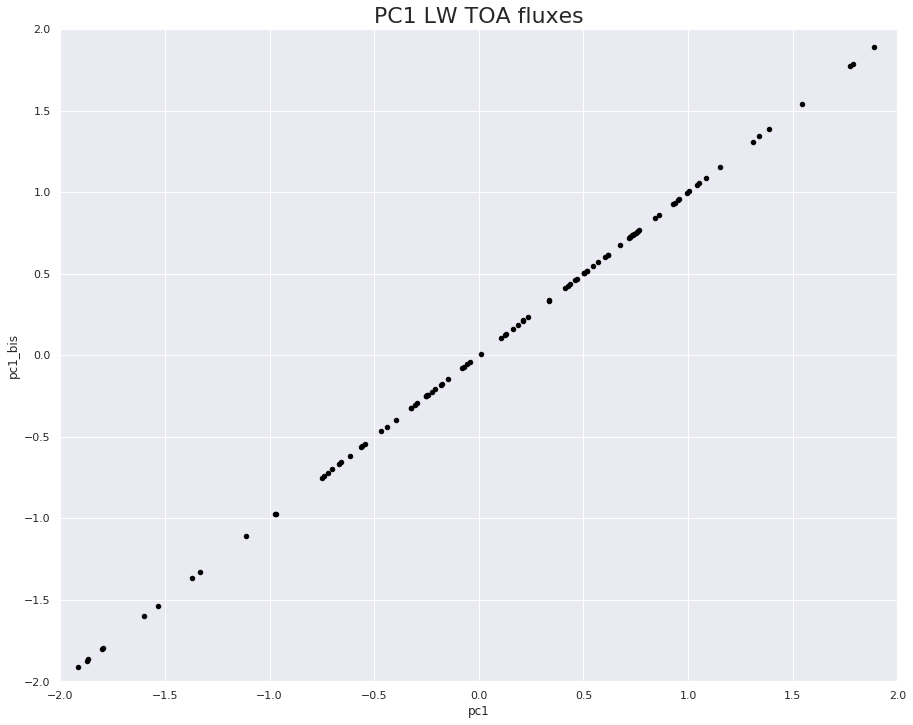

In [31]:
ax = plt.gca()
title = 'PC1 LW TOA fluxes'

df.plot(kind='scatter', x='pc1', y='pc1_bis', color='black', figsize=(15, 12), 
                     marker="o", ax = ax)
#plt.xlabel('Feedbacks (W.m^2)', fontsize=18)
#plt.ylabel('PC1 SW TOA fluxes', fontsize=18)
#plt.legend(['models', 'CERES dataset'])
plt.title(title, fontsize=22)
plt.ylim(-2.0,2.0)
plt.xlim(-2.0,2.0)

# Enregistrer la figure .....................

#plt.savefig("/data/home/globc/peatier/figures/Biases_VS_feedbacks.png", 
#        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

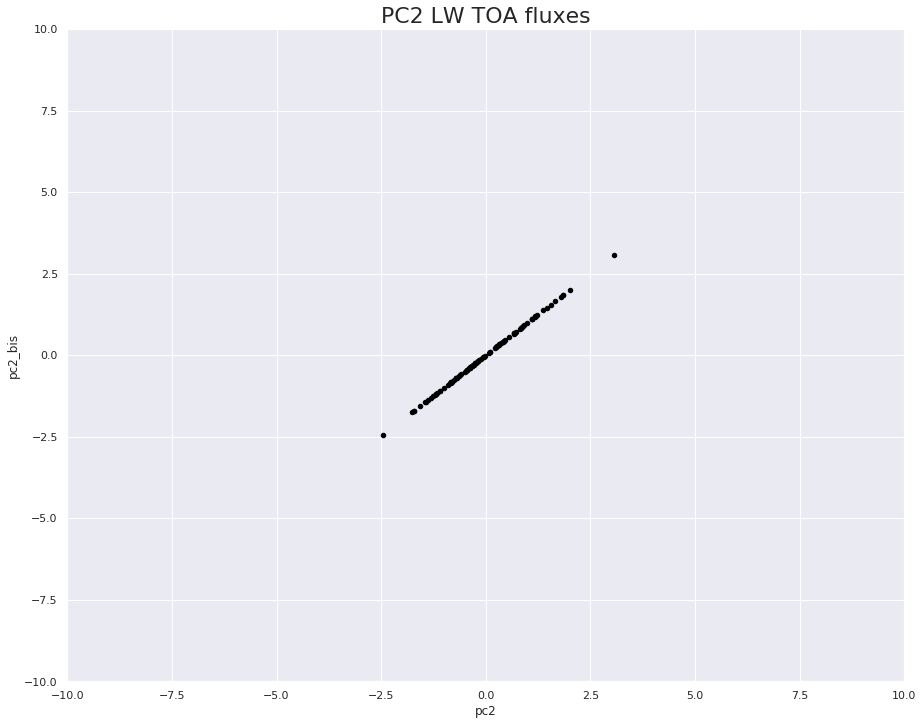

In [32]:
ax = plt.gca()
title = 'PC2 LW TOA fluxes'

df.plot(kind='scatter', x='pc2', y='pc2_bis', color='black', figsize=(15, 12), 
                     marker="o", ax = ax)
#plt.xlabel('Feedbacks (W.m^2)', fontsize=18)
#plt.ylabel('PC1 SW TOA fluxes', fontsize=18)
#plt.legend(['models', 'CERES dataset'])
plt.title(title, fontsize=22)
plt.ylim(-10,10)
plt.xlim(-10,10)

# Enregistrer la figure .....................

#plt.savefig("/data/home/globc/peatier/figures/Biases_VS_feedbacks.png", 
#        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

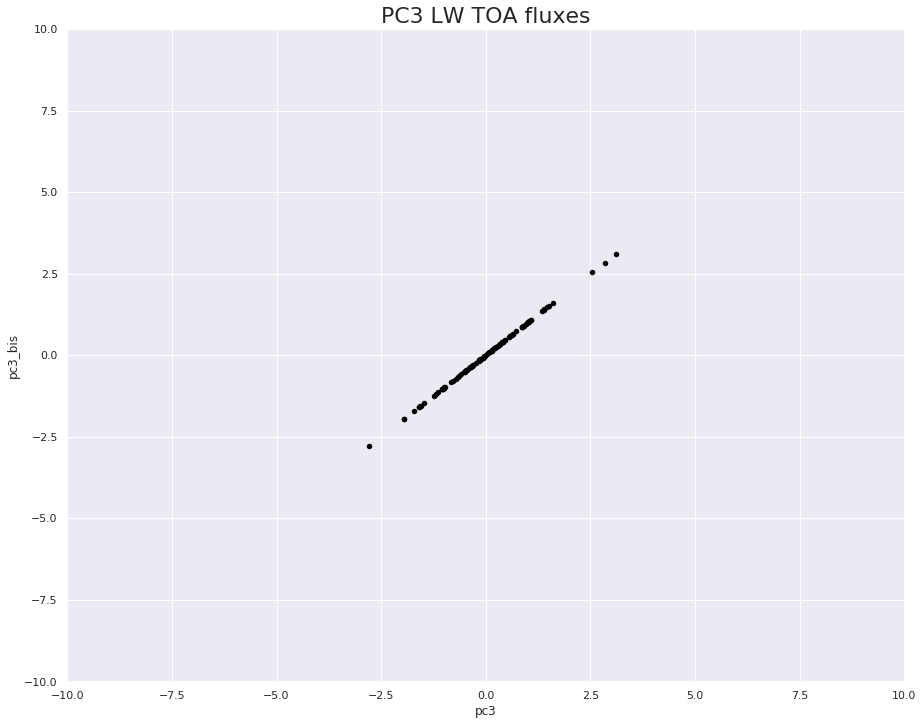

In [33]:
ax = plt.gca()
title = 'PC3 LW TOA fluxes'

df.plot(kind='scatter', x='pc3', y='pc3_bis', color='black', figsize=(15, 12), 
                     marker="o", ax = ax)
#plt.xlabel('Feedbacks (W.m^2)', fontsize=18)
#plt.ylabel('PC1 SW TOA fluxes', fontsize=18)
#plt.legend(['models', 'CERES dataset'])
plt.title(title, fontsize=22)
plt.ylim(-10,10)
plt.xlim(-10,10)

# Enregistrer la figure .....................

#plt.savefig("/data/home/globc/peatier/figures/Biases_VS_feedbacks.png", 
#        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

In [34]:
X_obs_bis = X_obs.expand_dims(dim={'dummy':range(0,102,1)})
X_obs_bis

<xarray.DataArray (dummy: 102, lat: 128, lon: 256)>
array([[[1.3451538 , 1.3451538 , 1.3451538 , ..., 1.5623932 ,
         1.3451538 , 1.3451538 ],
        [0.64837646, 0.64837646, 0.64837646, ..., 1.3423462 ,
         0.64837646, 0.64837646],
        [0.8112335 , 0.8112335 , 0.8112335 , ..., 1.3394012 ,
         0.8112335 , 0.8112335 ],
        ...,
        [5.514923  , 5.514923  , 5.514923  , ..., 5.288574  ,
         5.514923  , 5.514923  ],
        [4.857071  , 4.857071  , 4.857071  , ..., 4.77359   ,
         4.857071  , 4.857071  ],
        [6.354141  , 6.354141  , 6.354141  , ..., 6.3238525 ,
         6.354141  , 6.354141  ]],

       [[1.3451538 , 1.3451538 , 1.3451538 , ..., 1.5623932 ,
         1.3451538 , 1.3451538 ],
        [0.64837646, 0.64837646, 0.64837646, ..., 1.3423462 ,
         0.64837646, 0.64837646],
        [0.8112335 , 0.8112335 , 0.8112335 , ..., 1.3394012 ,
         0.8112335 , 0.8112335 ],
        ...,
        [5.514923  , 5.514923  , 5.514923  , ..., 5.288574  ,
         5.514923  , 5.514923  ],
        [4.857071  , 4.857071  , 4.857071  , ..., 4.77359   ,
         4.857071  , 4.857071  ],
        [6.354141  , 6.354141  , 6.354141  , ..., 6.3238525 ,
         6.354141  , 6.354141  ]],

       [[1.3451538 , 1.3451538 , 1.3451538 , ..., 1.5623932 ,
         1.3451538 , 1.3451538 ],
        [0.64837646, 0.64837646, 0.64837646, ..., 1.3423462 ,
         0.64837646, 0.64837646],
        [0.8112335 , 0.8112335 , 0.8112335 , ..., 1.3394012 ,
         0.8112335 , 0.8112335 ],
        ...,
        [5.514923  , 5.514923  , 5.514923  , ..., 5.288574  ,
         5.514923  , 5.514923  ],
        [4.857071  , 4.857071  , 4.857071  , ..., 4.77359   ,
         4.857071  , 4.857071  ],
        [6.354141  , 6.354141  , 6.354141  , ..., 6.3238525 ,
         6.354141  , 6.354141  ]],

       ...,

       [[1.3451538 , 1.3451538 , 1.3451538 , ..., 1.5623932 ,
         1.3451538 , 1.3451538 ],
        [0.64837646, 0.64837646, 0.64837646, ..., 1.3423462 ,
         0.64837646, 0.64837646],
        [0.8112335 , 0.8112335 , 0.8112335 , ..., 1.3394012 ,
         0.8112335 , 0.8112335 ],
        ...,
        [5.514923  , 5.514923  , 5.514923  , ..., 5.288574  ,
         5.514923  , 5.514923  ],
        [4.857071  , 4.857071  , 4.857071  , ..., 4.77359   ,
         4.857071  , 4.857071  ],
        [6.354141  , 6.354141  , 6.354141  , ..., 6.3238525 ,
         6.354141  , 6.354141  ]],

       [[1.3451538 , 1.3451538 , 1.3451538 , ..., 1.5623932 ,
         1.3451538 , 1.3451538 ],
        [0.64837646, 0.64837646, 0.64837646, ..., 1.3423462 ,
         0.64837646, 0.64837646],
        [0.8112335 , 0.8112335 , 0.8112335 , ..., 1.3394012 ,
         0.8112335 , 0.8112335 ],
        ...,
        [5.514923  , 5.514923  , 5.514923  , ..., 5.288574  ,
         5.514923  , 5.514923  ],
        [4.857071  , 4.857071  , 4.857071  , ..., 4.77359   ,
         4.857071  , 4.857071  ],
        [6.354141  , 6.354141  , 6.354141  , ..., 6.3238525 ,
         6.354141  , 6.354141  ]],

       [[1.3451538 , 1.3451538 , 1.3451538 , ..., 1.5623932 ,
         1.3451538 , 1.3451538 ],
        [0.64837646, 0.64837646, 0.64837646, ..., 1.3423462 ,
         0.64837646, 0.64837646],
        [0.8112335 , 0.8112335 , 0.8112335 , ..., 1.3394012 ,
         0.8112335 , 0.8112335 ],
        ...,
        [5.514923  , 5.514923  , 5.514923  , ..., 5.288574  ,
         5.514923  , 5.514923  ],
        [4.857071  , 4.857071  , 4.857071  , ..., 4.77359   ,
         4.857071  , 4.857071  ],
        [6.354141  , 6.354141  , 6.354141  , ..., 6.3238525 ,
         6.354141  , 6.354141  ]]], dtype=float32)
Coordinates:
  * dummy    (dummy) int64 0 1 2 3 4 5 6 7 8 9 ... 93 94 95 96 97 98 99 100 101
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
    mode     <U8 'rlutmean'

In [35]:
U_obs = np.dot(eofs_inv,X_obs_bis.transpose('lon','lat', 'dummy'))
#U_ens = U_ens.mean(dim=['lat','lon'])#.transpose()
U_obs

array([[[[-0.90530056, -0.90530056, -0.90530056, ..., -0.90530056,
          -0.90530056, -0.90530056],
         [-0.8920747 , -0.8920747 , -0.8920747 , ..., -0.8920747 ,
          -0.8920747 , -0.8920747 ],
         [-1.0847273 , -1.0847273 , -1.0847273 , ..., -1.0847273 ,
          -1.0847273 , -1.0847273 ],
         ...,
         [-0.4110377 , -0.4110377 , -0.4110377 , ..., -0.4110377 ,
          -0.4110377 , -0.4110377 ],
         [-0.5187186 , -0.5187186 , -0.5187186 , ..., -0.5187186 ,
          -0.5187186 , -0.5187186 ],
         [-0.7294016 , -0.7294016 , -0.7294016 , ..., -0.7294016 ,
          -0.7294016 , -0.7294016 ]],

        [[ 2.34117   ,  2.34117   ,  2.34117   , ...,  2.34117   ,
           2.34117   ,  2.34117   ],
         [ 2.4853811 ,  2.4853811 ,  2.4853811 , ...,  2.4853811 ,
           2.4853811 ,  2.4853811 ],
         [ 2.7814605 ,  2.7814605 ,  2.7814605 , ...,  2.7814605 ,
           2.7814605 ,  2.7814605 ],
         ...,
         [ 1.8579389 ,  1.8579389 

In [36]:
U_obs = xr.DataArray(U_obs, dims=['lon','eofs','lon2', 'dummy'])
U_obs_avg = U_obs[0,:,0,0].transpose()
U_obs_avg

<xarray.DataArray (eofs: 5)>
array([-0.90530056,  2.34117   , -1.7348833 ,  1.7361926 ,  0.22081728],
      dtype=float32)
Dimensions without coordinates: eofs

In [37]:
#Save the U_obs_avg 
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_obs_LW.npy', U_obs_avg)